## k_Nearest_Neighbor

다수결시 과반수를 넘겨야 하기에 k의 갯수(이웃의 갯수)는 홀수를 권장함

-> 특정값으로 편향될 수 있음

단순하고 성능은 우수하지만 속도가 느림

예측 전에 학습을 시키지 않아도 됨 (게으른 모델이라고도 함)

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 속성을 보고 포지션 예측하기 (지도 학습)

### 1. 데이터 가져오기

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('./data/basketball_stat.csv')
df

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5
...,...,...,...,...,...,...,...,...
95,Nikola Vucevic,C,0.3,6.1,10.4,2.8,1.0,1.0
96,Dwyane Wade,SG,0.8,6.2,4.5,3.8,1.4,0.7
97,Dion Waiters,SG,1.8,4.3,3.3,4.3,0.9,0.4
98,Hassan Whiteside,C,0.0,7.0,14.1,0.7,0.7,2.1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  100 non-null    object 
 1   Pos     100 non-null    object 
 2   3P      100 non-null    float64
 3   2P      100 non-null    float64
 4   TRB     100 non-null    float64
 5   AST     100 non-null    float64
 6   STL     100 non-null    float64
 7   BLK     100 non-null    float64
dtypes: float64(6), object(2)
memory usage: 6.4+ KB


In [5]:
df.Pos.value_counts()

SG    50
C     50
Name: Pos, dtype: int64

### 2. 데이터 시각화

In [6]:
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

스틸과 2점슛, 어시스트와 2점슛의 포지션(Pos) 별 분포도 출력

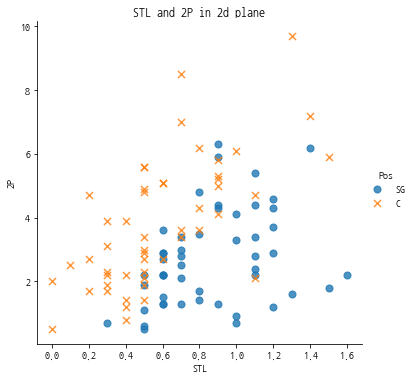

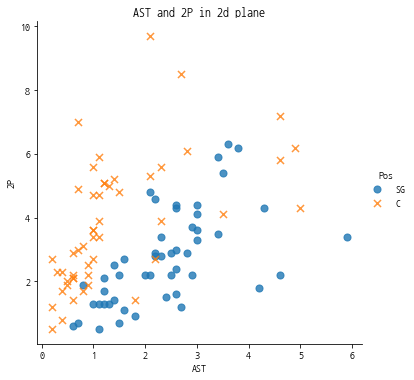

In [7]:
sns.lmplot(x = 'STL', y = '2P', data=df, 
           fit_reg=False,                # 데이터, x축, y축, 회귀선 표시 여부
           scatter_kws={'s': 50},         # 그래프에 표시될 표식의 크기
           markers=['o', 'x'], hue='Pos')
plt.title('STL and 2P in 2d plane')
plt.show()

sns.lmplot(x = 'AST', y = '2P', data=df, 
           fit_reg=False,
           scatter_kws={'s': 50},
           markers=['o', 'x'], hue='Pos')
plt.title('AST and 2P in 2d plane')
plt.show()

블로킹과 3점슛, 리바운드와 3점슛의 포지션(Pos) 별 분포도 출력

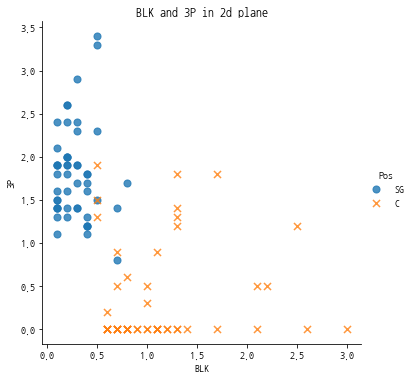

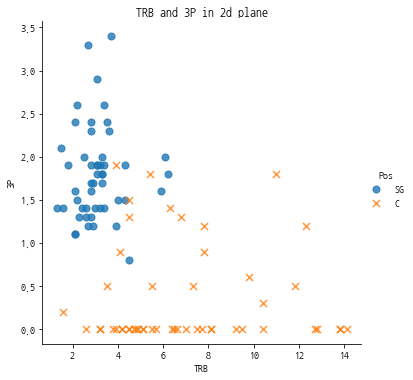

In [8]:
sns.lmplot(x = 'BLK', y = '3P', data=df, 
           fit_reg=False,                # 데이터, x축, y축, 회귀선 표시 여부
           scatter_kws={'s': 50},         # 그래프에 표시될 표식의 크기
           markers=['o', 'x'], hue='Pos')
plt.title('BLK and 3P in 2d plane')
plt.show()

sns.lmplot(x = 'TRB', y = '3P', data=df, 
           fit_reg=False,
           scatter_kws={'s': 50},
           markers=['o', 'x'], hue='Pos')
plt.title('TRB and 3P in 2d plane')
plt.show()

### 3. 데이터 정제

분별력이 있는 3점 슛을 사용

In [9]:
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True) 
# axis=1 : 열 단위, inplace=True : 실행된 데이터 결과에 반영

In [10]:
df

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5
...,...,...,...,...,...
95,Nikola Vucevic,C,0.3,10.4,1.0
96,Dwyane Wade,SG,0.8,4.5,0.7
97,Dion Waiters,SG,1.8,3.3,0.4
98,Hassan Whiteside,C,0.0,14.1,2.1


데이터를 학습 데이터와 테스트 데이터로 나눔

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train, test = train_test_split(df, train_size=0.8, test_size=0.2)
print(train.shape[0])
print(test.shape[0])

80
20


### 4. 최적의 kNN 파라미터 찾기

k Fold 교차 검증 사용

k-Fold 교차 검증 :기존 데이터를 k개로 나눠서 k번 정확도를 검증하는 방법임

In [13]:
from sklearn.model_selection import cross_val_score

k의 범위를 3부터 학습 데이터 갯수의 절반까지 지정함

In [14]:
k_list = []
for i in range(3, train.shape[0]//2, 2):
    k_list.append(i)
print(k_list)

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]


학습 데이터에서 학습과 학습 결과에 사용할 데이터를 저장함

In [15]:
x_train = train[['3P', 'TRB', 'BLK']]
y_train = train[['Pos']]

각각의 k별 10-fold 교차 검증 결과의 평균을 기억할 빈 리스트를 선언함

학습 데이터를 10조각으로 나눠 1조각을 검증 데이터로 사용하고 나머지 9조각을 학습 데이터로 사용해서 1번째 조각부터 10번쨰 조각까지 1번씩 검증하고 10번의 검증 결과를 10으로 나눈 평균을 검증 결과의 점수로 함

cross_validation_scores(model, X, Y, soring=None, cv=None)

    model : 회귀 분석 모형
    X : 독립변수, 학습 데이터
    Y : 종속변수, 결과
    soring : 성능 검증에 사용할 매개변수에 원하는 평가지표를 지정함
      -> 정확도를 의미하는 accuracy를 지정함
    cv : 교차 검증 생성기 객쳬 또는 숫자
      -> None이면 k-Fold(3), 숫자를 지정하면 k-Fold(숫자)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
cross_validation_scores = []
for k in k_list :
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train.values.ravel(), 
                             scoring='accuracy', cv=10)
    cross_validation_scores.append(scores.mean())
print(cross_validation_scores)

# n_neighbors : kNN 모델에서 사용할 이웃의 개수를 지정해서 kNN 모델을 만듦
# values.ravel()를 사용해서 2차원을 1차원으로 변경함

[0.925, 0.9, 0.9, 0.9125, 0.925, 0.9, 0.9125, 0.9125, 0.9125, 0.8875, 0.8875, 0.875, 0.875, 0.8625, 0.85, 0.85, 0.85, 0.8375, 0.8375]


각 k별로 출력된 정확도가 쉽게 이해하기 위해 시각화를 해서 최적의 k를 확인함

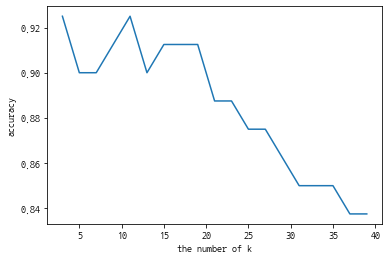

In [18]:
plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('accuracy')
plt.show()

예측율이 가장 높은 k를 선정함

In [19]:
optimal_k = k_list[cross_validation_scores.index(max(cross_validation_scores))]
print('최적의 k : {}'.format(optimal_k))

최적의 k : 3


### 5. 모델 테스트

분별력이 있다고 판단된 3점슛(3P), 블로킹(BLK), 리바운드(TRB) 속성으로 모들을 학습한 후 데스트를 진행함

학습과 테스트에 사용할 속성과 예측값을 지정함

In [20]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)

x_train = train[['3P', 'TRB', 'BLK']]
y_train = train[['Pos']]
knn.fit(x_train, y_train.values.ravel())

x_test = test[['3P', 'TRB', 'BLK']]
y_test = test[['Pos']]

테스트 수행

In [22]:
from sklearn.metrics import accuracy_score

In [24]:
predict = knn.predict(x_test)
print('정확도 : {}'.format(accuracy_score(y_test.values.ravel(), predict)))

정확도 : 0.9


In [26]:
comparison = pd.DataFrame({'예측값':predict,'실제값':y_test.values.ravel()})
comparison

,예측값,실제값
0,C,C
1,SG,SG
2,C,C
3,SG,SG
4,C,C
5,C,C
6,C,C
7,C,C
8,SG,SG
9,C,C


In [34]:
x = {'3P':[0, 3.9], 'BLK':[7.7, 0.3], 'TRB':[1, 0.1]}
x_test = pd.DataFrame(x)
print(x_test)

y = {'Pos':['C', 'SG']}
y_test = pd.DataFrame(y)
print(y_test)

predict = knn.predict(x_test)
print(predict)

print('정확도 : {}'.format(accuracy_score(y_test.values.ravel(), predict)))

comparison = pd.DataFrame({'예측값':predict,'실제값':y_test.values.ravel()})
print(comparison)

    3P  BLK  TRB
0  0.0  7.7  1.0
1  3.9  0.3  0.1
  Pos
0   C
1  SG
['C' 'SG']
정확도 : 1.0
  예측값 실제값
0   C   C
1  SG  SG
